# Laboratorio 2: CompuAlpes

- Juan Camilo Colmenares - 202011866
- Juan Montealegre - 202012723
- David Gonzales - 201815834

CompuAlpes es una reconocida tienda minorista que vende computadores portátiles de diferentes fabricantes y especificaciones técnicas. Con el auge de la tecnología y el creciente número de productos en el mercado, la empresa busca optimizar sus estrategias de fijación de precios y promociones para seguir siendo competitiva. Es en este último punto, donde ha identificado un reto relacionado con **determinar el precio adecuado para un portatil** ya que el mercado es dinámico y la valoración de las características técnicas cambia con el tiempo. Poner un precio demasiado alto puede alejar a los clientes, mientras que ponerlo demasiado bajo puede reducir los márgenes de ganancia.

Esto motivó a CompuAlpes a proponer el objetivo de este proyecto, en el cual se desea **construir un modelo de regresión que permita estimar el precio de un portátil a partir de sus especificaciones técnicas, determinando las que más impactan en el precio o que son, de acuerdo a la evidencia, irrelevantes para la estimación**. Este modelo permitirá a CompuAlpes tener una base objetiva y cuantitativa al momento de establecer precios para sus productos.

In [1]:
import numpy as np
import pandas as pd

from joblib import dump, load

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import scipy.stats as stats

### Carga de los datos

In [2]:
df = pd.read_csv('./data/202320_Laboratorio 2 - Regresión_data_laptop_data_train.csv')

## 1. Entendimiento de los datos

In [3]:
df.shape

(1216, 14)

In [4]:
df.dtypes

id               int64
Company         object
TypeName        object
Ram              int64
Weight         float64
Price          float64
TouchScreen      int64
Ips              int64
Ppi            float64
Cpu_brand       object
HDD            float64
SSD              int64
Gpu_brand       object
Os              object
dtype: object

In [5]:
df.sample(5)

,id,Company,TypeName,Ram,Weight,Price,TouchScreen,Ips,Ppi,Cpu_brand,HDD,SSD,Gpu_brand,Os
142,965,Dell,Notebook,4,2.25,302.137406,0,0,100.454670,Intel Core i3,1000.0,0,AMD,Others
705,816,Razer,Ultrabook,16,1.29,11.470547,1,1,352.465147,Intel Core i7,0.0,512,Intel,Windows
1199,381,Lenovo,Notebook,4,1.85,9.975738,0,0,141.211998,Intel Core i3,0.0,128,Intel,Others
660,688,HP,Notebook,6,2.65,10.319441,0,1,127.335675,AMD Processor,2000.0,0,AMD,Windows
1011,250,Dell,2 in 1 Convertible,8,2.08,10.683645,1,1,141.211998,Intel Core i7,1000.0,0,Intel,Windows


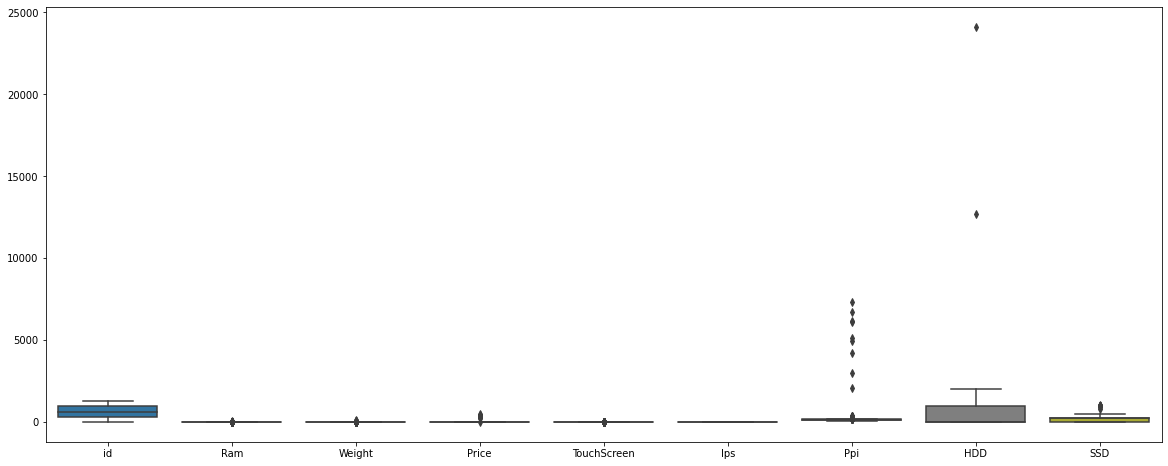

In [6]:
fig=plt.figure(figsize=(20,8))
ax = sns.boxplot(data=df, orient="v")

Para entrenar un modelo de regresión todas las variables de entrada (features) deben ser numéricas. Con ayuda de los expertos, se seleccionan las variables numéricas que se consideran más importantes para la estimación de la variable objetivo (target) `Price`.

Hay variables booleanas que deberían influir en el precio de una laptop como Ips pero para este modelo no parece aplicar.
[Aquí se habla de eso](https://towardsdatascience.com/machine-learning-102-logistic-regression-9e6dc2807772)

In [7]:
features = ['Ram', 'Weight', 'SSD','TouchScreen','Ips','HDD','Ppi']

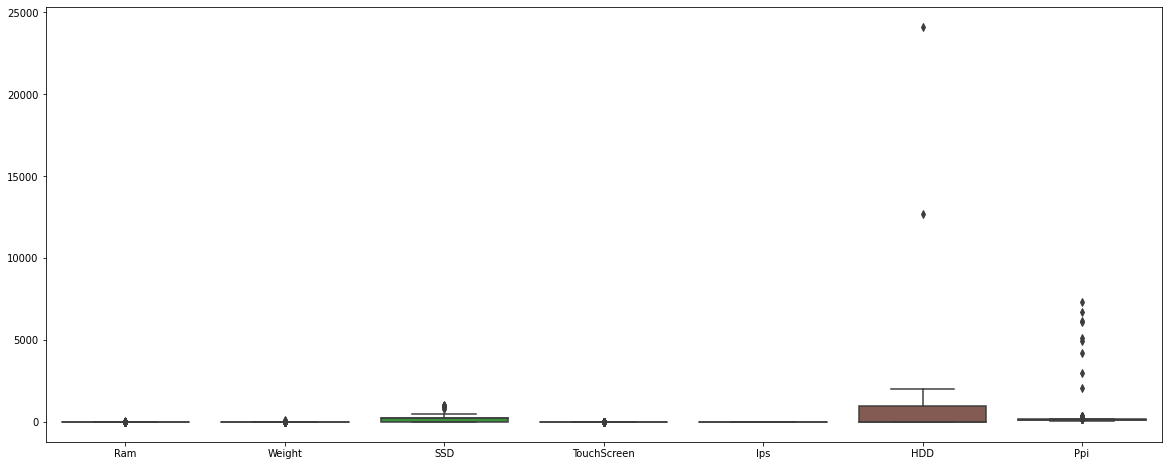

In [8]:
fig=plt.figure(figsize=(20,8))
ax = sns.boxplot(data=df[features], orient="v")

In [9]:
df[['Price'] + features].isnull().sum() / df.shape[0]

Price          0.012336
Ram            0.000000
Weight         0.018914
SSD            0.000000
TouchScreen    0.000000
Ips            0.000000
HDD            0.013158
Ppi            0.009868
dtype: float64

In [10]:
df.loc[df.duplicated(subset=features, keep=False)].sort_values(by=features).head(6)

,id,Company,TypeName,Ram,Weight,Price,TouchScreen,Ips,Ppi,Cpu_brand,HDD,SSD,Gpu_brand,Os
546,1126,Lenovo,2 in 1 Convertible,4,0.690,10.147262,1,1,224.173809,Other Intel Processor,0.0,0,Intel,Windows
930,1082,Lenovo,&&2 in 1 Convertible,4,0.690,10.446778,1,1,224.173809,Other Intel Processor,0.0,0,Intel,Windows
181,959,Acer,2 in 1 Convertible,4,1.250,9.939140,1,1,135.094211,Other Intel Processor,0.0,0,Intel,Others
1016,619,Acer,2 in 1 Convertible,4,1.250,9.913097,1,1,135.094211,Other Intel Processor,0.0,0,Intel,Others
373,457,Microsoft,Ultrabook,4,1.252,10.872255,1,0,200.842560,Other Intel Processor,0.0,128,Intel,Windows
502,70,Microsoft,Ultrabook,4,1.252,10.968576,1,0,200.842560,Intel Core i5,0.0,128,Intel,Windows


In [11]:
duplicated_rows = df.loc[df.duplicated(subset = features, keep = False)].shape[0]
duplicated_rows

542

In [12]:
print('Duplicates %:', (duplicated_rows / df.shape[0]))

Duplicates %: 0.4457236842105263


In [13]:
df.loc[df.duplicated(subset = features+['Price'], keep = False)].sort_values(by=features).head(6)

,id,Company,TypeName,Ram,Weight,Price,TouchScreen,Ips,Ppi,Cpu_brand,HDD,SSD,Gpu_brand,Os
128,645,Lenovo,Notebook,4,1.43,9.588689,0,0,111.935204,Other Intel Processor,0.0,0,Intel,Windows
1096,645,Lenovo,Notebook,4,1.43,9.588689,0,0,111.935204,Other Intel Processor,0.0,0,Intel,Windows
395,212,HP,Notebook,4,2.10,9.830633,0,0,141.211998,Intel Core i3,500.0,0,Intel,Others
999,101,HP,Notebook,4,2.10,9.830633,0,0,141.211998,AMD Processor,500.0,0,AMD,Windows
422,884,Dell,&&Notebook,4,2.20,9.886358,0,0,100.454670,Other Intel Processor,500.0,0,Intel,Windows
622,1172,Asus,Notebook,4,2.20,9.886358,0,0,100.454670,Other Intel Processor,500.0,0,Intel,Windows


In [14]:
duplicated_rows = df.loc[df.duplicated(subset = features + ['Price'], keep = False)].shape[0]
duplicated_rows

20

In [15]:
print('Duplicates %:', (duplicated_rows / df.shape[0]))

Duplicates %: 0.01644736842105263


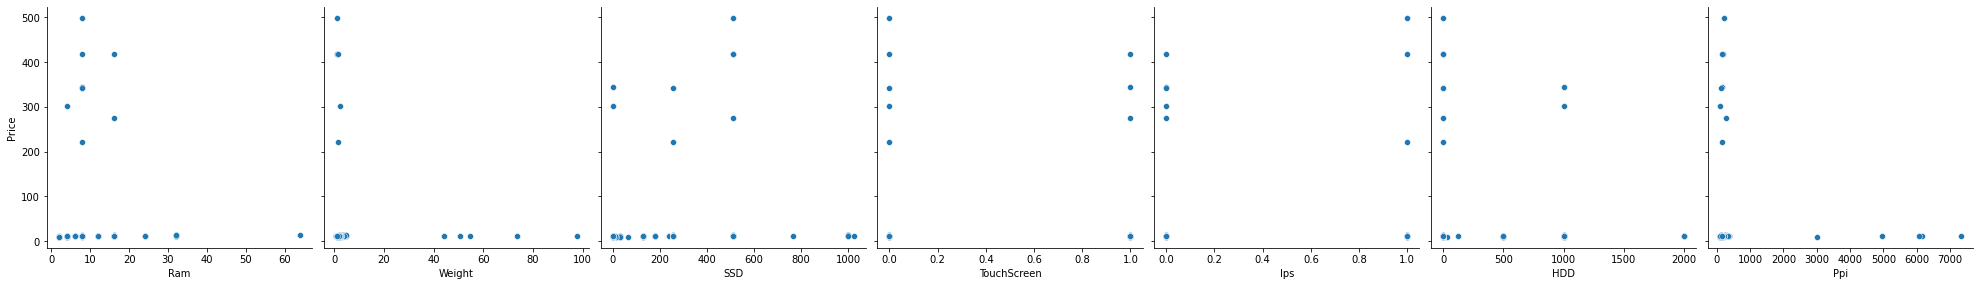

In [16]:
sns.pairplot(df, height = 4, y_vars = 'Price', x_vars = features, kind = 'scatter')

<Axes: >

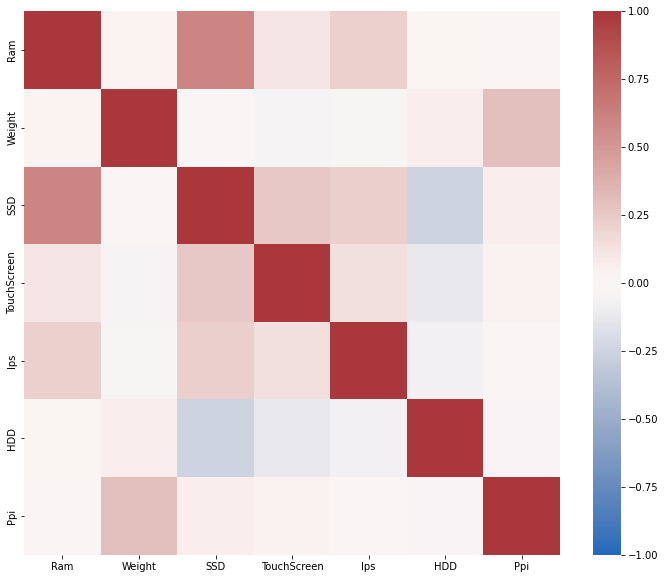

In [17]:
plt.figure(figsize = (12, 10))
sns.heatmap(df[features].corr(), cmap = 'vlag', vmin = -1, vmax = 1)

## 2. Preparación de datos

In [18]:
df.shape

(1216, 14)

In [19]:
df = df.dropna(subset = ['Price'] + features)

In [20]:
df.shape

(1170, 14)

In [21]:
df[['Price'] + features].isnull().sum() / df.shape[0]

Price          0.0
Ram            0.0
Weight         0.0
SSD            0.0
TouchScreen    0.0
Ips            0.0
HDD            0.0
Ppi            0.0
dtype: float64

In [22]:
df.Price.describe()

count    1170.000000
mean       12.380936
std        24.435044
min         9.134616
25%        10.402328
50%        10.882316
75%        11.288115
max       499.766079
Name: Price, dtype: float64

In [23]:
df.Price.unique()

array([ 10.08480861,  10.56311104,  11.06480418,  10.97771698,
        11.55063273,  11.01872094,   9.83063295,  11.23748812,
         9.26886585,  10.83096982,  11.12075716,  10.3368635 ,
        11.14491104,   9.85888341,  11.05642892,  11.54031804,
        10.91384551,  10.45099374,  11.51192496,   9.66929317,
        10.65892197,  10.10461124,  11.41394456,  10.81276508,
        11.10565954,  11.47054726,  11.73730601,  11.13017638,
        11.21835895,  10.349205  ,  10.5108023 ,  11.55778513,
        10.7406    ,  10.97861739,  10.34990418,  10.77684406,
        11.57295735,  11.0222083 ,  11.77899608,  11.18267988,
        11.54754948,  12.58788256,  11.73261217,  10.46628456,
        10.55758617,  11.79920696,   9.99658438,  10.5344678 ,
        10.90898405,  10.48134509,  11.219074  ,   9.77161878,
        11.11838843,  10.59431336,  10.52521177,  12.00593479,
        10.69578118,  11.3582826 ,  10.76565826,  11.26721724,
        11.41335615,  11.02307825,  11.00261819,  10.77

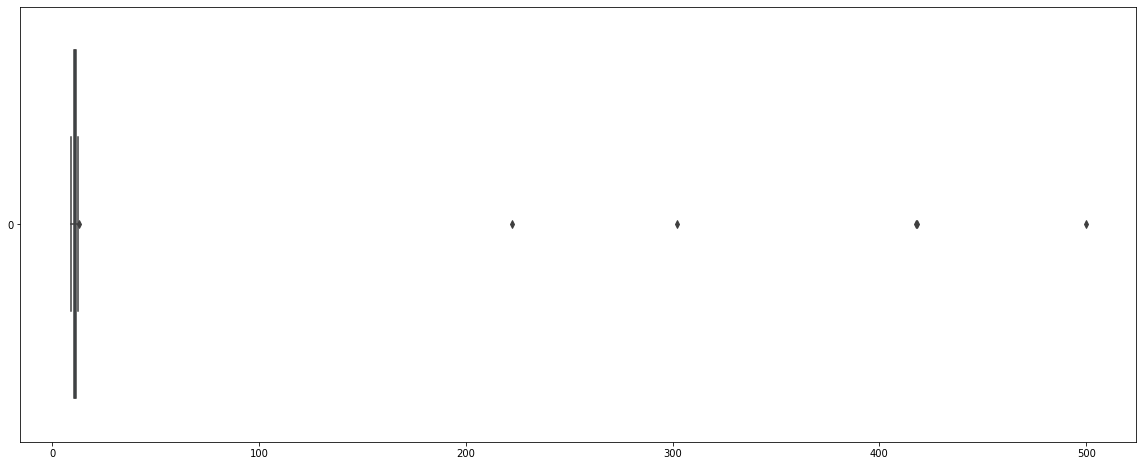

In [24]:
fig=plt.figure(figsize=(20,8))
ax = sns.boxplot(data=df['Price'], orient="h")

## 3. Particionamiento del conjunto de datos en entrenamiento y prueba

In [25]:
X_train, X_test, y_train, y_test = train_test_split(df[features],df['Price'], test_size=0.3, random_state=1)

In [26]:
X_train.shape, y_train.shape

((819, 7), (819,))

In [27]:
X_test.shape, y_test.shape  

((351, 7), (351,))

## 4. Entrenamiento de un primer modelo de regresión lineal


In [28]:
regression= LinearRegression()  

In [29]:
regression.fit(X_train, y_train)

LinearRegression()

## 5. Interpretación de los coeficientes y del intercepto

In [30]:
pd.DataFrame({'features': features, 'coef': regression.coef_})  

,features,coef
0,Ram,-0.245801
1,Weight,-0.039049
2,SSD,0.011762
3,TouchScreen,-1.774996
4,Ips,-0.055916
5,HDD,0.001349
6,Ppi,-0.000127


In [31]:
regression.intercept_

11.665933013999242

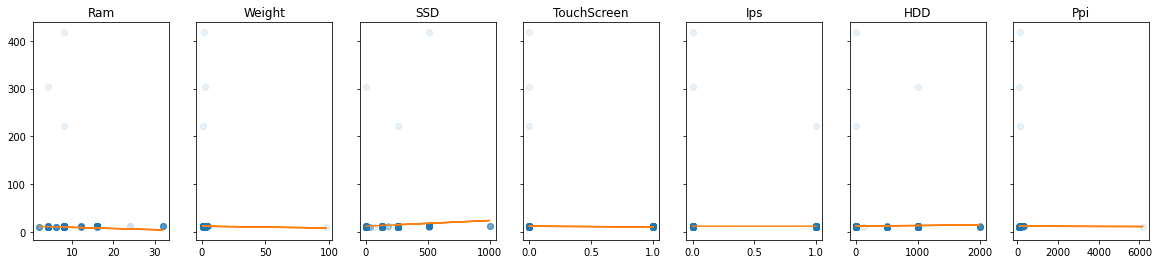

In [32]:
f, axs = plt.subplots(1, len(features), sharey=True, figsize=(20, 4))

for i in range(len(features)):
    col = features[i]
    x = X_train[col]
    m = regression.coef_[i]
    b = regression.intercept_

    axs[i].plot(x, y_train, "o", alpha=0.1)
    axs[i].plot(x, x * m + b)
    axs[i].set_title(col)

### 4.2. Validación (evaluación) del modelo

**Mean Absolute Error (MAE)**

In [33]:
print("Train:", mean_absolute_error(y_train, regression.predict(X_train)))
print("Test:", mean_absolute_error(y_test, regression.predict(X_test)))

Train: 2.58389684942793
Test: 4.074492267892132


**Root Mean Squeared Error (RMSE)**

In [34]:
print("Train:", np.sqrt(mean_squared_error(y_train, regression.predict(X_train))))
print("Test:", np.sqrt(mean_squared_error(y_test, regression.predict(X_test))))

Train: 18.90442285640839
Test: 33.797872951813844


**Análisis del error**

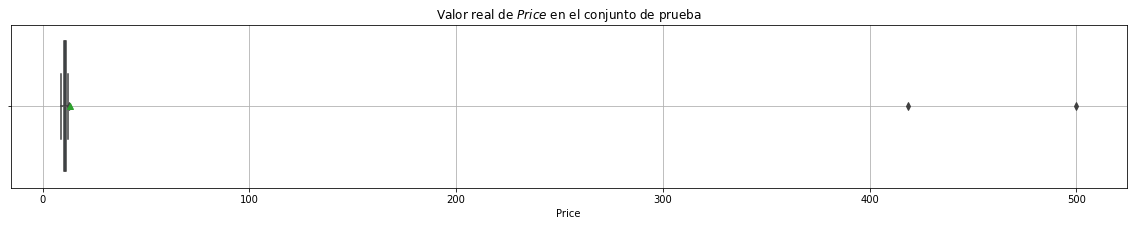

In [35]:
plt.figure(figsize=(20, 3))
sns.boxplot(x=y_test, showmeans=True, orient="h")
plt.title("Valor real de $\t{Price}$ en el conjunto de prueba")
plt.grid()
plt.show()

In [36]:
y_test.describe(percentiles=[0.25, 0.5, 0.75, 0.99])

count    351.000000
mean      13.341128
std       33.934355
min        9.134616
25%       10.328152
50%       10.841452
75%       11.234697
99%       12.312879
max      499.766079
Name: Price, dtype: float64

## 6. Entrenamiento de un segundo modelo retirando outliner

In [37]:
df.sample(5)

,id,Company,TypeName,Ram,Weight,Price,TouchScreen,Ips,Ppi,Cpu_brand,HDD,SSD,Gpu_brand,Os
549,456,Dell,Notebook,8,4.42,11.599203,0,1,127.335675,Intel Core i7,1000.0,0,Nvidia,Windows
381,727,Dell,2 in 1 Convertible,4,1.71,10.450994,1,0,165.632118,Intel Core i3,1000.0,0,Intel,Windows
1136,184,Xiaomi,Notebook,8,1.95,11.064804,0,1,141.211998,Intel Core i5,0.0,256,Nvidia,Others
216,1148,HP,Notebook,8,1.88,11.340108,0,0,141.211998,Intel Core i5,0.0,256,Intel,Windows
677,379,Acer,Notebook,8,2.40,10.716080,0,0,141.211998,Intel Core i7,1000.0,0,Nvidia,Others


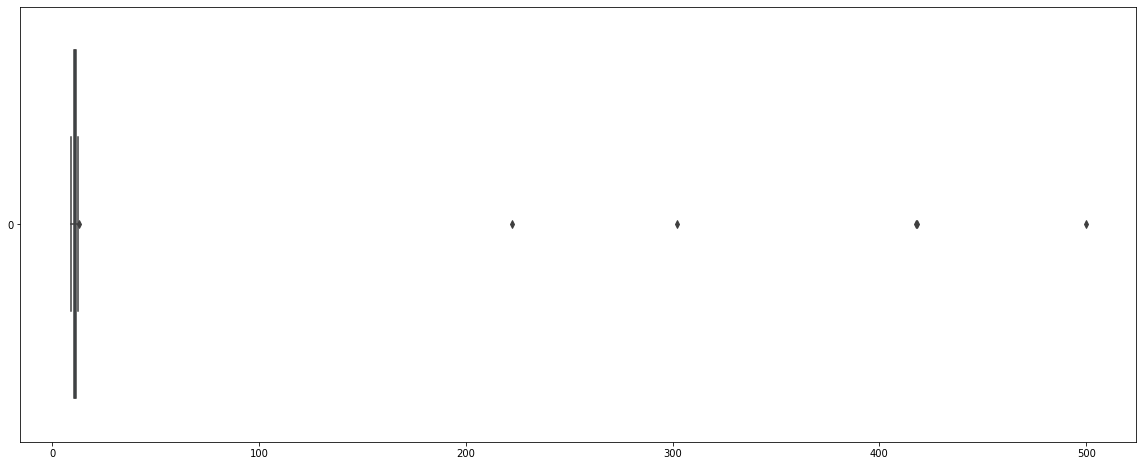

In [38]:
fig=plt.figure(figsize=(20,8))
ax = sns.boxplot(data=df['Price'], orient="h")

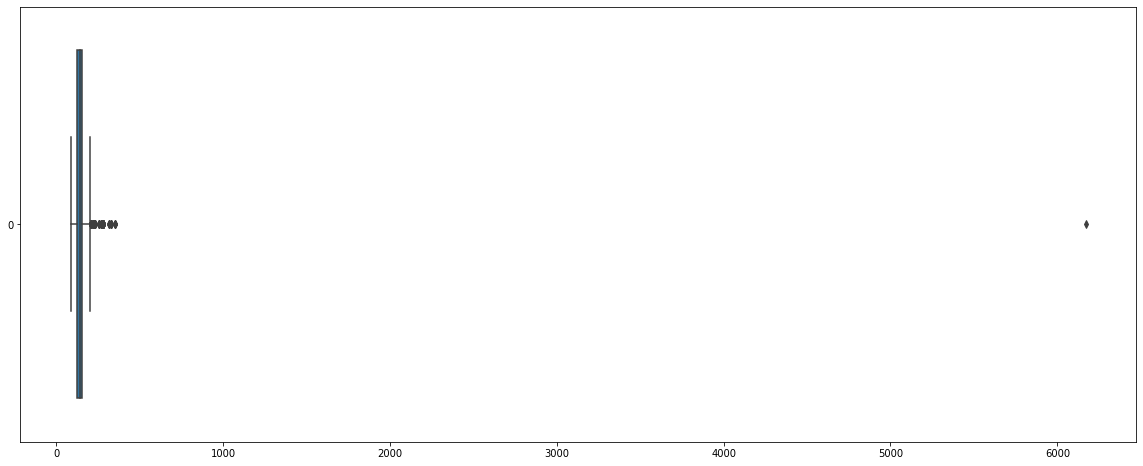

In [39]:
fig=plt.figure(figsize=(20,8))
ax = sns.boxplot(data=df['Ppi'], orient="h")

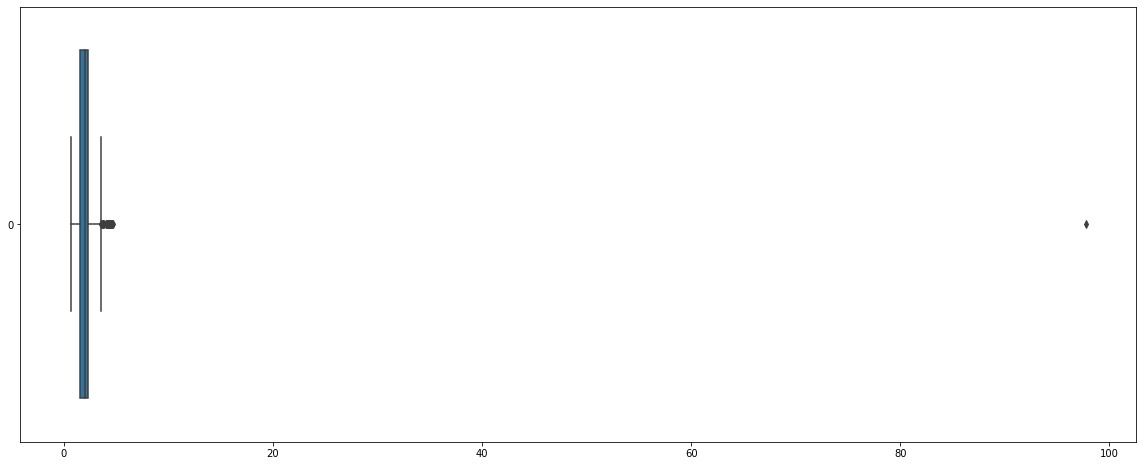

In [40]:
fig=plt.figure(figsize=(20,8))
ax = sns.boxplot(data=df['Weight'], orient="h")

In [41]:
df=df[(df.Price < 13) & (df.Ppi < 2000) & (df.Weight < 50)]

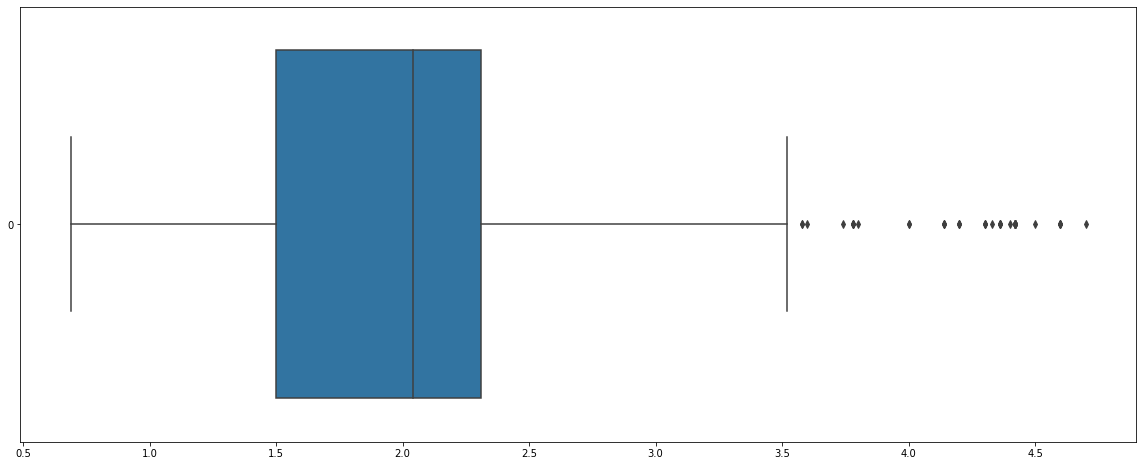

In [87]:
fig=plt.figure(figsize=(20,8))
ax = sns.boxplot(data=df['Weight'], orient="h")

In [42]:
X_train, X_test, y_train, y_test = train_test_split(df[features],df['Price'], test_size=0.3, random_state=1)

In [43]:
regression= LinearRegression()  

In [44]:
regression.fit(X_train, y_train)

LinearRegression()

In [45]:
pd.DataFrame({'features': features, 'coef': regression.coef_})  

,features,coef
0,Ram,0.048404
1,Weight,0.060715
2,SSD,0.000980
3,TouchScreen,-0.022572
4,Ips,0.112529
5,HDD,0.000035
6,Ppi,0.003195


In [46]:
regression.intercept_

9.606617657790936

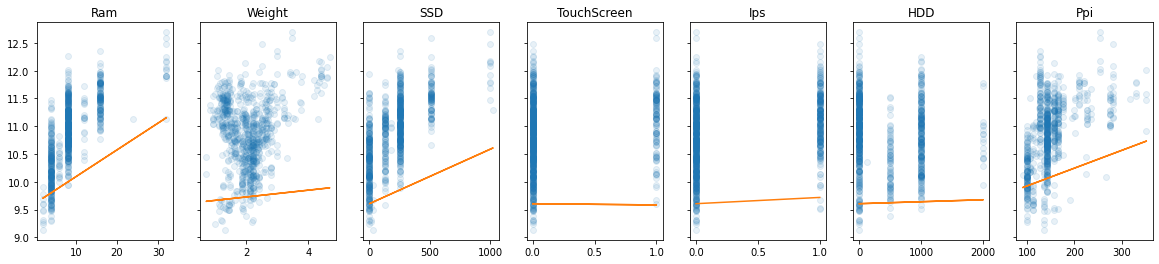

In [47]:
f, axs = plt.subplots(1, len(features), sharey=True, figsize=(20, 4))

for i in range(len(features)):
    col = features[i]
    x = X_train[col]
    m = regression.coef_[i]
    b = regression.intercept_

    axs[i].plot(x, y_train, "o", alpha=0.1)
    axs[i].plot(x, x * m + b)
    axs[i].set_title(col)

In [48]:
print("MSA")
print("Train:", mean_absolute_error(y_train, regression.predict(X_train)))
print("Test:", mean_absolute_error(y_test, regression.predict(X_test)))
print("RMSE")
print("Train:", np.sqrt(mean_squared_error(y_train, regression.predict(X_train))))
print("Test:", np.sqrt(mean_squared_error(y_test, regression.predict(X_test))))

MSA
Train: 0.31315675824688743
Test: 0.3085563403364242
RMSE
Train: 0.39049869812634547
Test: 0.3869609240871415


## 6. Entrenamiento de un segundo modelo aplicando normalización

In [49]:
pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("model", LinearRegression())
    ]
)

In [50]:
X_train, X_test, y_train, y_test = train_test_split(df[features],df['Price'], test_size=0.3, random_state=1)

In [51]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('model', LinearRegression())])

In [52]:
pd.DataFrame({'features': features, 'coef': pipeline['model'].coef_})

,features,coef
0,Ram,0.245168
1,Weight,0.041045
2,SSD,0.183090
3,TouchScreen,-0.008111
4,Ips,0.051121
5,HDD,0.017837
6,Ppi,0.140867


In [53]:
pipeline['model'].intercept_

10.843754471504695

In [54]:
y_train.mean(), y_test.mean()

(10.843754471504695, 10.823711998106853)

In [55]:
print("MAE:")
print("Train:", mean_absolute_error(y_train, pipeline.predict(X_train)))
print("Test:", mean_absolute_error(y_test, pipeline.predict(X_test)))
print("\nRMSE:")
print("Train:", np.sqrt(mean_squared_error(y_train, pipeline.predict(X_train))))
print("Test:", np.sqrt(mean_squared_error(y_test, pipeline.predict(X_test))))


MAE:
Train: 0.3131567582468873
Test: 0.3085563403364234

RMSE:
Train: 0.39049869812634547
Test: 0.38696092408714156


### 6.2 Tercer modelo retirando outliner

In [56]:
q1 = y_train.quantile(0.25)
q3 = y_train.quantile(0.75)
iqr = q3 - q1
threshold = q3 + 1.5 * iqr
threshold

12.590330802672073

In [57]:
y_train = y_train.loc[y_train <= threshold]
X_train = X_train.loc[y_train.index]

In [58]:
y_test = y_test.loc[y_test <= threshold]
X_test = X_test.loc[y_test.index]

In [59]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('model', LinearRegression())])

In [60]:
pd.DataFrame({'features': features, 'coef': pipeline['model'].coef_})

,features,coef
0,Ram,0.243274
1,Weight,0.042462
2,SSD,0.182352
3,TouchScreen,-0.006978
4,Ips,0.049778
5,HDD,0.017399
6,Ppi,0.141053


In [61]:
pipeline['model'].intercept_

10.841481794189782

In [62]:
y_train.mean(), y_test.mean()

(10.841481794189782, 10.823711998106853)

In [63]:
print("MAE:")
print("Train:", mean_absolute_error(y_train, pipeline.predict(X_train)))
print("Test:", mean_absolute_error(y_test, pipeline.predict(X_test)))
print("\nRMSE:")
print("Train:", np.sqrt(mean_squared_error(y_train, pipeline.predict(X_train))))
print("Test:", np.sqrt(mean_squared_error(y_test, pipeline.predict(X_test))))


MAE:
Train: 0.312962076531091
Test: 0.30817701971640105

RMSE:
Train: 0.39040935893807266
Test: 0.3868107608284173


### 7.1. Colinealidad

<Axes: >

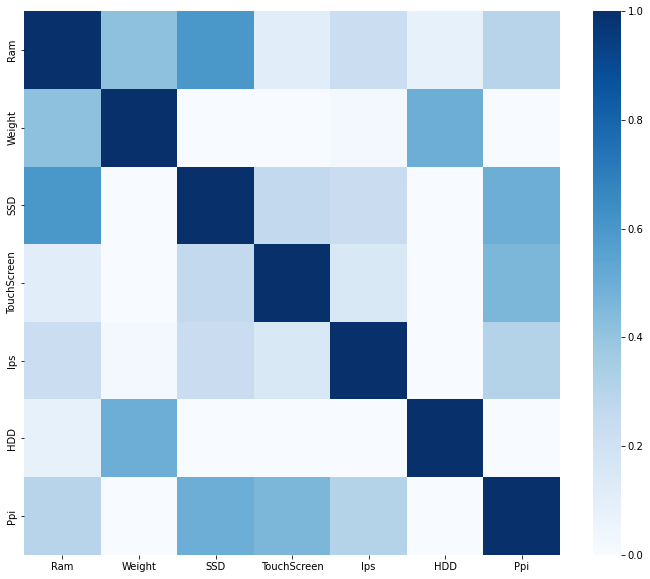

In [64]:
plt.figure(figsize=(12, 10))
sns.heatmap(X_train.corr(), cmap="Blues", vmin=0, vmax=1)

In [65]:
df[features].corr()

,Ram,Weight,SSD,TouchScreen,Ips,HDD,Ppi
Ram,1.000000,0.401344,0.597973,0.108652,0.217978,0.088136,0.295715
Weight,0.401344,1.000000,-0.045188,-0.280058,0.030378,0.509990,-0.313192
SSD,0.597973,-0.045188,1.000000,0.243592,0.218692,-0.400464,0.501862
TouchScreen,0.108652,-0.280058,0.243592,1.000000,0.128434,-0.197693,0.442048
Ips,0.217978,0.030378,0.218692,0.128434,1.000000,-0.093149,0.293570
HDD,0.088136,0.509990,-0.400464,-0.197693,-0.093149,1.000000,-0.297652
Ppi,0.295715,-0.313192,0.501862,0.442048,0.293570,-0.297652,1.000000


In [66]:
features2=['Ram','SSD','TouchScreen']

In [67]:
df.Ram.describe()

count    1163.000000
mean        8.526225
std         5.150234
min         2.000000
25%         4.000000
50%         8.000000
75%         8.000000
max        64.000000
Name: Ram, dtype: float64

In [68]:
df.SSD.describe()

count    1163.000000
mean      187.594153
std       186.979912
min         0.000000
25%         0.000000
50%       256.000000
75%       256.000000
max      1024.000000
Name: SSD, dtype: float64

In [69]:
pipeline.fit(X_train[features2], y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('model', LinearRegression())])

In [70]:
pd.DataFrame({'columns': features2, 'coef': pipeline['model'].coef_})

,columns,coef
0,Ram,0.290647
1,SSD,0.216346
2,TouchScreen,0.034544


In [71]:
pipeline['model'].intercept_

10.841481794189782

In [72]:
print('MAE:')
print('Train:', mean_absolute_error(y_train, pipeline.predict(X_train[features2])))
print('Test:', mean_absolute_error(y_test, pipeline.predict(X_test[features2])))
print('\nRMSE:')
print('Train:', np.sqrt(mean_squared_error(y_train, pipeline.predict(X_train[features2]))))
print('Test:', np.sqrt(mean_squared_error(y_test, pipeline.predict(X_test[features2]))))

MAE:
Train: 0.330454730638564
Test: 0.32163639421136336

RMSE:
Train: 0.4101244617674925
Test: 0.4092497140901838


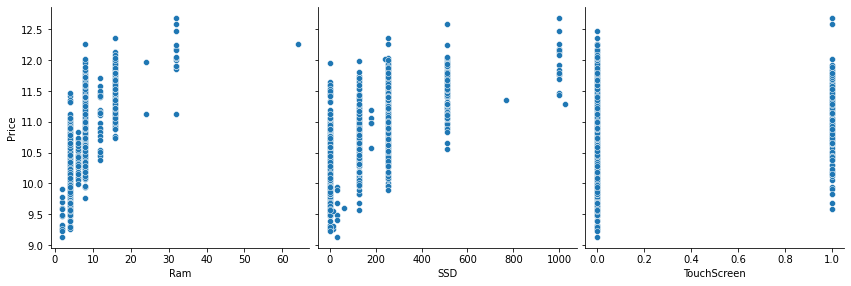

In [73]:
sns.pairplot(df, height = 4, y_vars = 'Price', x_vars = features2, kind = 'scatter')

In [74]:
pipeline = Pipeline(
    [
        ('poly', PolynomialFeatures(degree = 2, include_bias = False)),
        ('scaler', StandardScaler()),
        ('model', LinearRegression())
    ]
)

In [75]:
pipeline.fit(X_train[features2], y_train)

Pipeline(steps=[('poly', PolynomialFeatures(include_bias=False)),
                ('scaler', StandardScaler()), ('model', LinearRegression())])

In [76]:
pd.DataFrame({'columns': pipeline['poly'].get_feature_names_out(), 'coef': pipeline['model'].coef_})

,columns,coef
0,Ram,6.965167e-01
1,SSD,3.536498e-01
2,TouchScreen,3.904768e+12
3,Ram^2,-3.292462e-01
4,Ram SSD,-1.064186e-01
5,Ram TouchScreen,-1.522862e-01
6,SSD^2,-1.324325e-01
7,SSD TouchScreen,6.008522e-02
8,TouchScreen^2,-3.904768e+12


In [77]:
print('MAE:')
print('Train:', mean_absolute_error(y_train, pipeline.predict(X_train[features2])))
print('Test:', mean_absolute_error(y_test, pipeline.predict(X_test[features2])))
print('\nRMSE:')
print('Train:', np.sqrt(mean_squared_error(y_train, pipeline.predict(X_train[features2]))))
print('Test:', np.sqrt(mean_squared_error(y_test, pipeline.predict(X_test[features2]))))

MAE:
Train: 0.29185722665087166
Test: 0.28852589461026684

RMSE:
Train: 0.36511079153988407
Test: 0.4074740565485277


### 7.3. Normalidad de los errores

In [78]:
errors =(pipeline.predict(X_train[features2]) - y_train).values

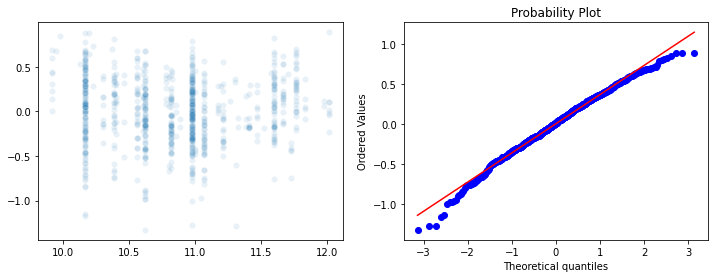

In [79]:
fig, axes = plt.subplots(1, 2, figsize = (12, 4))

# Dispersión
sns.scatterplot(x = pipeline.predict(X_train[features2]), y = errors, alpha = 0.1, ax = axes[0])

# q-q plot
_ = stats.probplot(errors, dist = 'norm', plot = axes[1])

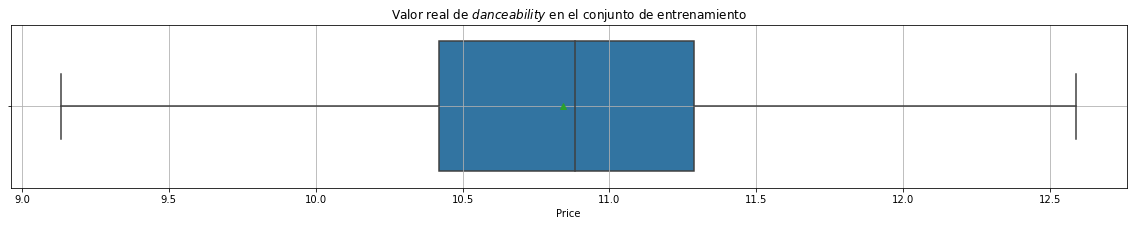

In [80]:
plt.figure(figsize = (20, 3))
sns.boxplot(x = y_train, showmeans = True, orient = 'h')
plt.title('Valor real de $\t{danceability}$ en el conjunto de entrenamiento')
plt.grid()
plt.show()

Valores atípicos

In [81]:
q1 = y_train.quantile(0.25)
q3 = y_train.quantile(0.75)
iqr = q3 - q1
threshold = q3 + 1.5 * iqr
threshold

12.589079551374383

In [82]:
y_train = y_train.loc[y_train <= threshold]
X_train = X_train.loc[y_train.index]

In [83]:
y_test = y_test.loc[y_test <= threshold]
X_test = X_test.loc[y_test.index]

In [84]:
pipeline.fit(X_train[features2], y_train)

Pipeline(steps=[('poly', PolynomialFeatures(include_bias=False)),
                ('scaler', StandardScaler()), ('model', LinearRegression())])

In [85]:
pd.DataFrame({'columns': pipeline['poly'].get_feature_names_out(), 'coef': pipeline['model'].coef_})

,columns,coef
0,Ram,6.965167e-01
1,SSD,3.536498e-01
2,TouchScreen,3.904768e+12
3,Ram^2,-3.292462e-01
4,Ram SSD,-1.064186e-01
5,Ram TouchScreen,-1.522862e-01
6,SSD^2,-1.324325e-01
7,SSD TouchScreen,6.008522e-02
8,TouchScreen^2,-3.904768e+12


In [86]:
print('MAE:')
print('Train:', mean_absolute_error(y_train, pipeline.predict(X_train[features2])))
print('Test:', mean_absolute_error(y_test, pipeline.predict(X_test[features2])))
print('\nRMSE:')
print('Train:', np.sqrt(mean_squared_error(y_train, pipeline.predict(X_train[features2]))))
print('Test:', np.sqrt(mean_squared_error(y_test, pipeline.predict(X_test[features2]))))

MAE:
Train: 0.29185722665087166
Test: 0.28852589461026684

RMSE:
Train: 0.36511079153988407
Test: 0.4074740565485277
